In [7]:
# this program uses a neural network called LSTM
# to predict the closing price of a stock using past 60 day data 


Load Packages and Download stock price .

In [11]:
import warnings 
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment 
from numpy.linalg import LinAlgError
import pandas_datareader as web 
import statsmodels.tsa.api as tsa 
import matplotlib.pyplot as plt 
from itertools import product
from tqdm import tqdm 
import seaborn as sns 
import pandas as pd 
import numpy as np 
import yfinance as yf 
sns.set_style("whitegrid")

stock_df = yf.download(tickers = "aapl", start= "2012-01-01", end = "2023-01-29")

stock_log = np.log(stock_df["Adj Close"]).diff().dropna()

stock_log

[*********************100%***********************]  1 of 1 completed


Date
2012-01-04    0.005359
2012-01-05    0.011041
2012-01-06    0.010399
2012-01-09   -0.001587
2012-01-10    0.003574
                ...   
2023-01-23    0.023229
2023-01-24    0.010013
2023-01-25   -0.004712
2023-01-26    0.014695
2023-01-27    0.013591
Name: Adj Close, Length: 2785, dtype: float64

Correlation Diagram

In [12]:
def plot_correlogram(x, lags = None, title = None):
    lags = min(10, int(len(x)/5)) if lags is None else lags 
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (14,8))
    x.plot(ax = axes[0][0], title = "Residuals")
    x.rolling(21).mean().plot(ax = axes[0][0], c="k", lw = 1)
    q_p = np.max(q_stat(acf(x, nlags = lags), len(x))[1])
    stats = f'Q-stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]: > 11.2f}'
    axes[0][0].text(x = .02, y =.85, s = stats, transform = axes[0][0].transAxes)
    probplot(x, plot = axes[0][1])
    mean, var ,skew, kurtosis = moment(x, moment = [1,2,3,4])
    
    s = f'Mean:{mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f} \nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y= .75, s=s, transform = axes[0][1].transAxes)
    plot_acf(x=x, lags = lags, zero =False, ax = axes[1][0])
    plot_pacf(x, lags = lags, zero =False, ax = axes[1][1])
    axes[1][0].set_xlabel("Lag")
    axes[1][1].set_xlabel("Lag")
    fig.suptitle(title, fontsize = 14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top = .9)
    
    return

<H2> Visualizing Daily Volatility <H2>

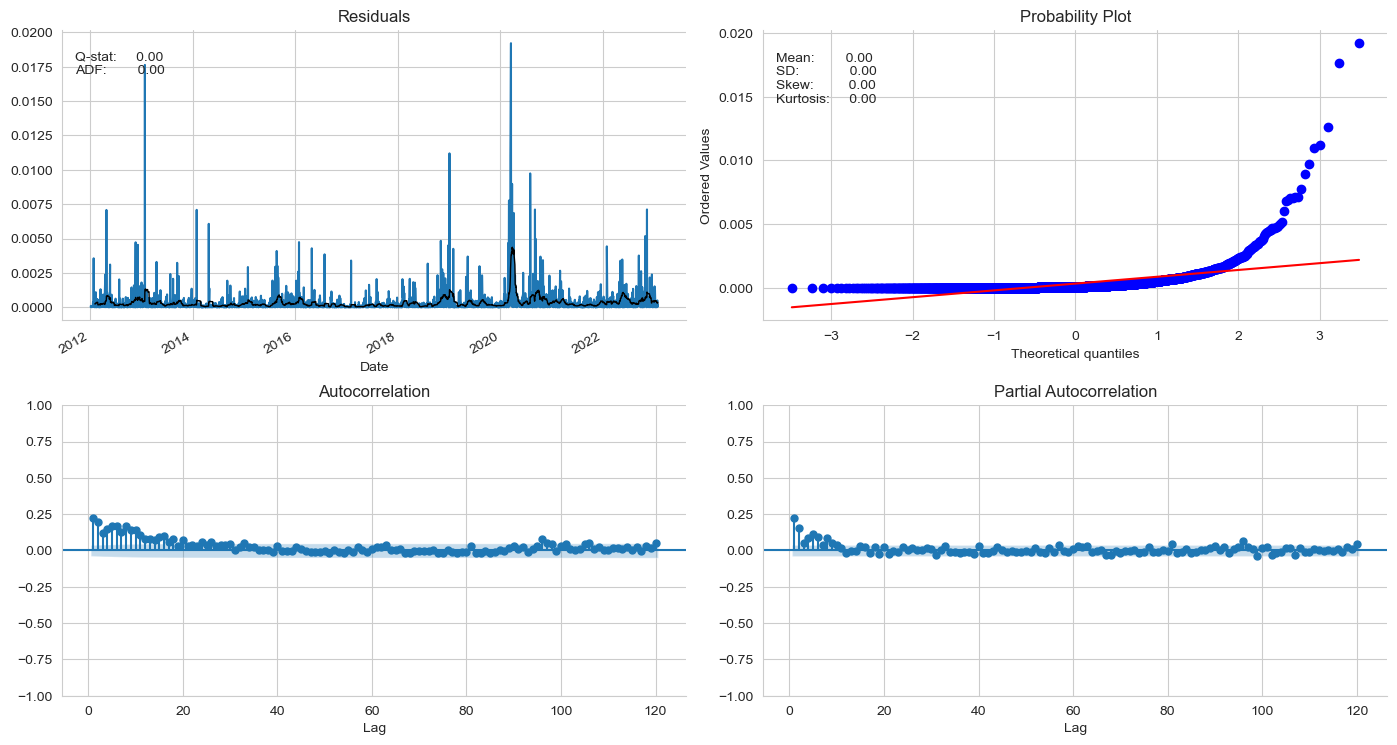

In [15]:
stock_daily_vol = (stock_log-stock_log.mean())**2

plot_correlogram(x = stock_daily_vol,
                 lags = 120,
                 title = None)

In [20]:
from arch import arch_model

trainsize = 10 * 252

data = stock_log.clip(lower= stock_log.quantile(.05),
                      upper = stock_log.quantile(.95))

# whole sample length in years EX DATA: 11 years 
T = len(stock_log)

results = {}

for p in range(1,5):
    
    for q in range(1,5):
       print(f'{p} | {q} ')
       result = []
       
       # set train and test data by defining the values
       for s, t in enumerate(range(trainsize, T-1)):
           train_set = data.iloc[s:t]
           test_set = data.iloc[t+1]
           model = arch_model(y = train_set,p=p,q=q).fit(disp= "off")
           forecast = model.forecast(horizon = 1)
           mu = forecast.mean.iloc[-1,0]
           var = forecast.variance.iloc[-1,0]
           result.append([(test_set - mu)**2, var])
       df = pd.DataFrame(result, columns = ["y_true", "y_pred"])
        
       results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))
        
    
           


1 | 1 
1 | 2 
1 | 3 
1 | 4 
2 | 1 
2 | 2 
2 | 3 
2 | 4 
3 | 1 
3 | 2 
3 | 3 
3 | 4 
4 | 1 
4 | 2 
4 | 3 
4 | 4 


In [21]:
# 1|1 , 1|2, 1|3 So on should create 16 different models
results

{(1, 1): 0.000302003491599783,
 (1, 2): 0.00030266698616362,
 (1, 3): 0.00030214127471318804,
 (1, 4): 0.00030224493550121736,
 (2, 1): 0.0003016599480863339,
 (2, 2): 0.00030212184432714664,
 (2, 3): 0.000301863727443655,
 (2, 4): 0.00030262516392397536,
 (3, 1): 0.00030138964486009116,
 (3, 2): 0.00030151295490812055,
 (3, 3): 0.0003027905590617144,
 (3, 4): 0.00030341085007332846,
 (4, 1): 0.000301217732223612,
 (4, 2): 0.0003010083656944917,
 (4, 3): 0.0003016337578401906,
 (4, 4): 0.0003024970765916503}

In [22]:
pd.DataFrame(results,index = pd.Series(0)).unstack().idxmin()

(4, 2, 0)

In [24]:
data = stock_log.clip(lower = stock_log.quantile(.05),
                      upper = stock_log.quantile(.95))

best_model = arch_model(y = data, p = 3, q =3).fit(update_freq = 5, disp = "off")
print(best_model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7961.64
Distribution:                  Normal   AIC:                          -15907.3
Method:            Maximum Likelihood   BIC:                          -15859.8
                                        No. Observations:                 2785
Date:                Mon, Mar 27 2023   Df Residuals:                     2784
Time:                        23:36:35   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.2638e-03  8.894e-05     14.211  7.868e-46 [1.

In [41]:
data = stock_log.to_frame("stock_log_ret")
data["variance"] = data["stock_log_ret"].rolling(70).var()

data = data["2020":]

def predict_volatility(x):
    best_model = arch_model(y = x, p = 3, q = 3).fit(update_freq = 5, disp = 'off')
    
    variance_forecast = best_model.forecast(horizon = 1).variance.iloc[-1,0]
    print(x.index[-1])
    
    return variance_forecast

data["predictions"] = data["stock_log_ret"].rolling(70).apply(lambda x: predict_volatility(x))

data = data.dropna()

data

2020-04-13 00:00:00
2020-04-14 00:00:00
2020-04-15 00:00:00
2020-04-16 00:00:00
2020-04-17 00:00:00
2020-04-20 00:00:00
2020-04-21 00:00:00
2020-04-22 00:00:00
2020-04-23 00:00:00
2020-04-24 00:00:00
2020-04-27 00:00:00
2020-04-28 00:00:00
2020-04-29 00:00:00
2020-04-30 00:00:00
2020-05-01 00:00:00
2020-05-04 00:00:00
2020-05-05 00:00:00
2020-05-06 00:00:00
2020-05-07 00:00:00
2020-05-08 00:00:00
2020-05-11 00:00:00
2020-05-12 00:00:00
2020-05-13 00:00:00
2020-05-14 00:00:00
2020-05-15 00:00:00
2020-05-18 00:00:00
2020-05-19 00:00:00
2020-05-20 00:00:00
2020-05-21 00:00:00
2020-05-22 00:00:00
2020-05-26 00:00:00
2020-05-27 00:00:00
2020-05-28 00:00:00
2020-05-29 00:00:00
2020-06-01 00:00:00
2020-06-02 00:00:00
2020-06-03 00:00:00
2020-06-04 00:00:00
2020-06-05 00:00:00
2020-06-08 00:00:00
2020-06-09 00:00:00
2020-06-10 00:00:00
2020-06-11 00:00:00
2020-06-12 00:00:00
2020-06-15 00:00:00
2020-06-16 00:00:00
2020-06-17 00:00:00
2020-06-18 00:00:00
2020-06-19 00:00:00
2020-06-22 00:00:00


/Users/liambaker/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2020-08-10 00:00:00
2020-08-11 00:00:00
2020-08-12 00:00:00
2020-08-13 00:00:00
2020-08-14 00:00:00
2020-08-17 00:00:00
2020-08-18 00:00:00
2020-08-19 00:00:00
2020-08-20 00:00:00
2020-08-21 00:00:00


/Users/liambaker/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2020-08-24 00:00:00
2020-08-25 00:00:00
2020-08-26 00:00:00
2020-08-27 00:00:00
2020-08-28 00:00:00
2020-08-31 00:00:00
2020-09-01 00:00:00
2020-09-02 00:00:00
2020-09-03 00:00:00
2020-09-04 00:00:00
2020-09-08 00:00:00
2020-09-09 00:00:00
2020-09-10 00:00:00
2020-09-11 00:00:00
2020-09-14 00:00:00
2020-09-15 00:00:00
2020-09-16 00:00:00


/Users/liambaker/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2020-09-17 00:00:00
2020-09-18 00:00:00


/Users/liambaker/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2020-09-21 00:00:00
2020-09-22 00:00:00
2020-09-23 00:00:00


/Users/liambaker/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2020-09-24 00:00:00
2020-09-25 00:00:00
2020-09-28 00:00:00
2020-09-29 00:00:00


/Users/liambaker/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2020-09-30 00:00:00
2020-10-01 00:00:00
2020-10-02 00:00:00
2020-10-05 00:00:00
2020-10-06 00:00:00
2020-10-07 00:00:00
2020-10-08 00:00:00
2020-10-09 00:00:00
2020-10-12 00:00:00
2020-10-13 00:00:00
2020-10-14 00:00:00
2020-10-15 00:00:00
2020-10-16 00:00:00
2020-10-19 00:00:00
2020-10-20 00:00:00
2020-10-21 00:00:00
2020-10-22 00:00:00
2020-10-23 00:00:00
2020-10-26 00:00:00
2020-10-27 00:00:00
2020-10-28 00:00:00
2020-10-29 00:00:00
2020-10-30 00:00:00
2020-11-02 00:00:00
2020-11-03 00:00:00
2020-11-04 00:00:00
2020-11-05 00:00:00
2020-11-06 00:00:00
2020-11-09 00:00:00
2020-11-10 00:00:00
2020-11-11 00:00:00
2020-11-12 00:00:00
2020-11-13 00:00:00
2020-11-16 00:00:00
2020-11-17 00:00:00
2020-11-18 00:00:00
2020-11-19 00:00:00
2020-11-20 00:00:00
2020-11-23 00:00:00
2020-11-24 00:00:00
2020-11-25 00:00:00
2020-11-27 00:00:00
2020-11-30 00:00:00
2020-12-01 00:00:00
2020-12-02 00:00:00
2020-12-03 00:00:00
2020-12-04 00:00:00
2020-12-07 00:00:00
2020-12-08 00:00:00
2020-12-09 00:00:00


/Users/liambaker/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-03-02 00:00:00
2021-03-03 00:00:00


/Users/liambaker/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-03-04 00:00:00
2021-03-05 00:00:00
2021-03-08 00:00:00
2021-03-09 00:00:00
2021-03-10 00:00:00
2021-03-11 00:00:00
2021-03-12 00:00:00
2021-03-15 00:00:00
2021-03-16 00:00:00
2021-03-17 00:00:00
2021-03-18 00:00:00
2021-03-19 00:00:00
2021-03-22 00:00:00
2021-03-23 00:00:00
2021-03-24 00:00:00
2021-03-25 00:00:00
2021-03-26 00:00:00
2021-03-29 00:00:00
2021-03-30 00:00:00
2021-03-31 00:00:00
2021-04-01 00:00:00
2021-04-05 00:00:00
2021-04-06 00:00:00
2021-04-07 00:00:00
2021-04-08 00:00:00
2021-04-09 00:00:00
2021-04-12 00:00:00
2021-04-13 00:00:00
2021-04-14 00:00:00
2021-04-15 00:00:00
2021-04-16 00:00:00
2021-04-19 00:00:00
2021-04-20 00:00:00
2021-04-21 00:00:00
2021-04-22 00:00:00
2021-04-23 00:00:00
2021-04-26 00:00:00
2021-04-27 00:00:00
2021-04-28 00:00:00
2021-04-29 00:00:00
2021-04-30 00:00:00
2021-05-03 00:00:00
2021-05-04 00:00:00
2021-05-05 00:00:00
2021-05-06 00:00:00
2021-05-07 00:00:00
2021-05-10 00:00:00
2021-05-11 00:00:00
2021-05-12 00:00:00
2021-05-13 00:00:00


/Users/liambaker/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-09-27 00:00:00
2021-09-28 00:00:00


/Users/liambaker/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-09-29 00:00:00
2021-09-30 00:00:00
2021-10-01 00:00:00


/Users/liambaker/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-10-04 00:00:00


/Users/liambaker/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-10-05 00:00:00


/Users/liambaker/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-10-06 00:00:00
2021-10-07 00:00:00
2021-10-08 00:00:00
2021-10-11 00:00:00
2021-10-12 00:00:00
2021-10-13 00:00:00
2021-10-14 00:00:00
2021-10-15 00:00:00
2021-10-18 00:00:00
2021-10-19 00:00:00
2021-10-20 00:00:00
2021-10-21 00:00:00
2021-10-22 00:00:00
2021-10-25 00:00:00
2021-10-26 00:00:00
2021-10-27 00:00:00
2021-10-28 00:00:00
2021-10-29 00:00:00
2021-11-01 00:00:00
2021-11-02 00:00:00
2021-11-03 00:00:00
2021-11-04 00:00:00
2021-11-05 00:00:00
2021-11-08 00:00:00
2021-11-09 00:00:00
2021-11-10 00:00:00
2021-11-11 00:00:00
2021-11-12 00:00:00
2021-11-15 00:00:00
2021-11-16 00:00:00
2021-11-17 00:00:00
2021-11-18 00:00:00
2021-11-19 00:00:00
2021-11-22 00:00:00
2021-11-23 00:00:00
2021-11-24 00:00:00
2021-11-26 00:00:00
2021-11-29 00:00:00
2021-11-30 00:00:00
2021-12-01 00:00:00
2021-12-02 00:00:00
2021-12-03 00:00:00
2021-12-06 00:00:00
2021-12-07 00:00:00
2021-12-08 00:00:00
2021-12-09 00:00:00
2021-12-10 00:00:00
2021-12-13 00:00:00
2021-12-14 00:00:00
2021-12-15 00:00:00


/Users/liambaker/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2022-11-14 00:00:00
2022-11-15 00:00:00
2022-11-16 00:00:00
2022-11-17 00:00:00
2022-11-18 00:00:00


/Users/liambaker/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2022-11-21 00:00:00
2022-11-22 00:00:00
2022-11-23 00:00:00
2022-11-25 00:00:00
2022-11-28 00:00:00
2022-11-29 00:00:00
2022-11-30 00:00:00
2022-12-01 00:00:00
2022-12-02 00:00:00
2022-12-05 00:00:00
2022-12-06 00:00:00
2022-12-07 00:00:00
2022-12-08 00:00:00
2022-12-09 00:00:00
2022-12-12 00:00:00
2022-12-13 00:00:00
2022-12-14 00:00:00
2022-12-15 00:00:00
2022-12-16 00:00:00
2022-12-19 00:00:00
2022-12-20 00:00:00
2022-12-21 00:00:00
2022-12-22 00:00:00
2022-12-23 00:00:00
2022-12-27 00:00:00
2022-12-28 00:00:00
2022-12-29 00:00:00
2022-12-30 00:00:00
2023-01-03 00:00:00
2023-01-04 00:00:00
2023-01-05 00:00:00
2023-01-06 00:00:00
2023-01-09 00:00:00
2023-01-10 00:00:00
2023-01-11 00:00:00
2023-01-12 00:00:00
2023-01-13 00:00:00
2023-01-17 00:00:00
2023-01-18 00:00:00
2023-01-19 00:00:00
2023-01-20 00:00:00
2023-01-23 00:00:00
2023-01-24 00:00:00
2023-01-25 00:00:00
2023-01-26 00:00:00
2023-01-27 00:00:00


,stock_log_ret,variance,predictions
Date,,,
2020-04-13,0.019438,0.001727,0.000785
2020-04-14,0.049269,0.001756,0.001070
2020-04-15,-0.009169,0.001756,0.001195
2020-04-16,0.007914,0.001756,0.001388
2020-04-17,-0.013661,0.001758,0.000384
...,...,...,...
2023-01-23,0.023229,0.000592,0.000567
2023-01-24,0.010013,0.000593,0.000568
2023-01-25,-0.004712,0.000577,0.000553


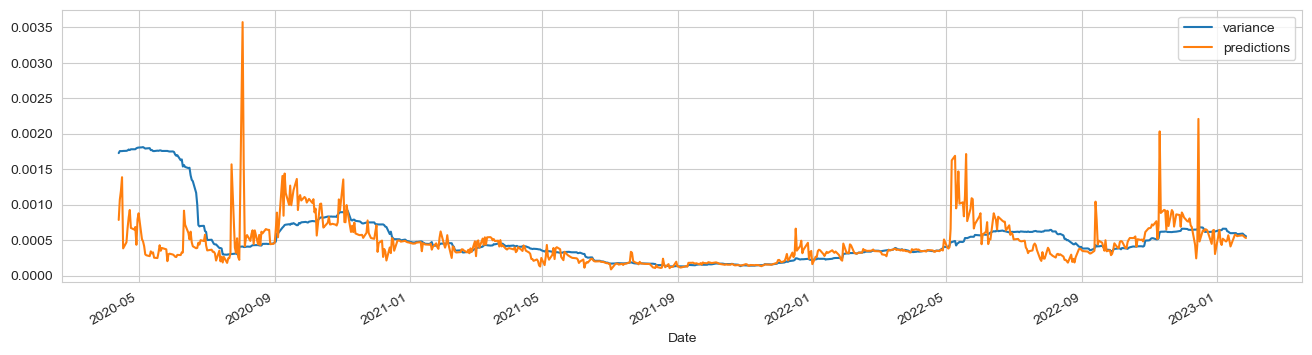

In [42]:
data[["variance", "predictions"]].plot(figsize = (16,4))
plt.show()

In [43]:
from pykalman import KalmanFilter 

def KalmanFilterAverage(x):
    kf = KalmanFilter(transition_matrices= [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance = 1,
                      transition_covariance = .01)
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index= x.index)
    return state_means

data["fixed_predictions"] = KalmanFilterAverage(data["predictions"])

data

,stock_log_ret,variance,predictions,fixed_predictions
Date,,,,
2020-04-13,0.019438,0.001727,0.000785,0.000393
2020-04-14,0.049269,0.001756,0.001070,0.000621
2020-04-15,-0.009169,0.001756,0.001195,0.000769
2020-04-16,0.007914,0.001756,0.001388,0.000900
2020-04-17,-0.013661,0.001758,0.000384,0.000807
...,...,...,...,...
2023-01-23,0.023229,0.000592,0.000567,0.000563
2023-01-24,0.010013,0.000593,0.000568,0.000564
2023-01-25,-0.004712,0.000577,0.000553,0.000563


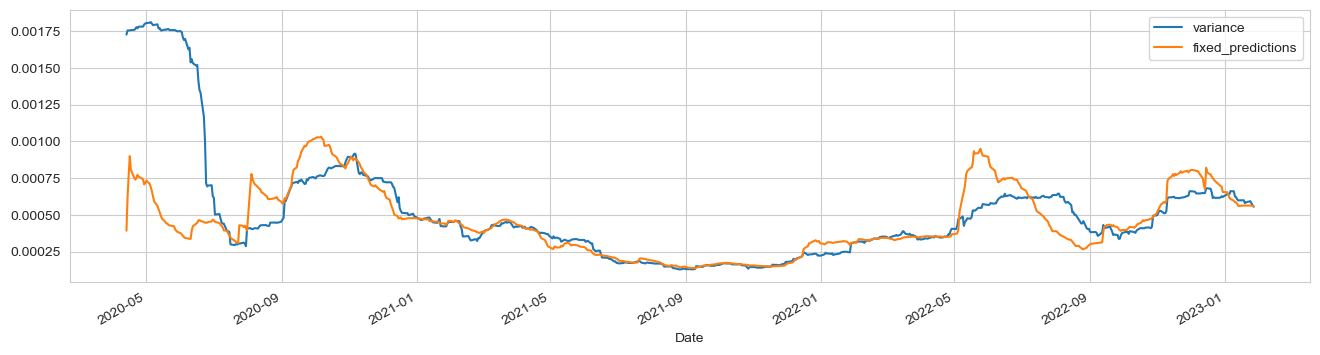

In [44]:
data[["variance", "fixed_predictions"]].plot(figsize = (16,4))
plt.show()

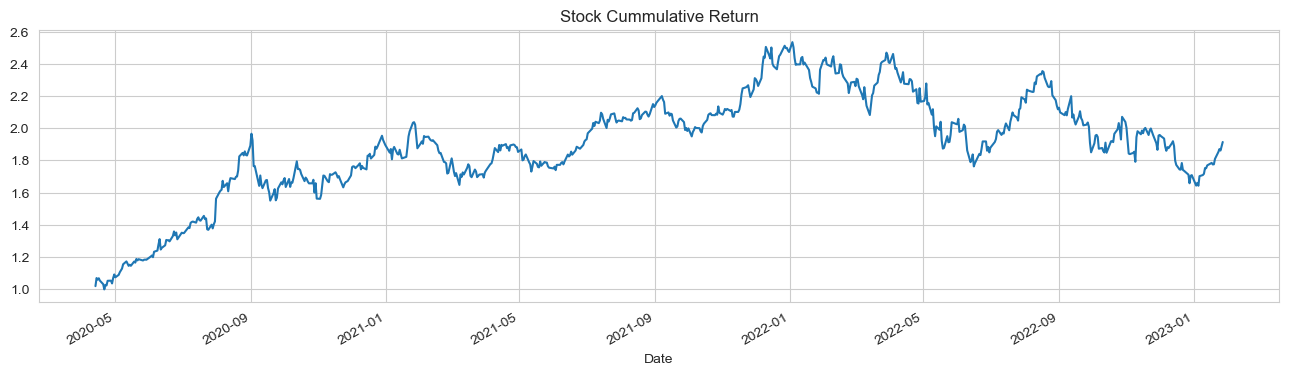

In [45]:
np.exp(np.log1p(data["stock_log_ret"]).cumsum()).plot(figsize = (16,4))
plt.title("Stock Cummulative Return")
plt.show()

In [51]:
# sharpe ratio
print(f'Sharpe Ratio {(data["stock_log_ret"].mean()/data["stock_log_ret"].std())*(252**.5)}')

Sharpe Ratio 0.877749016631271


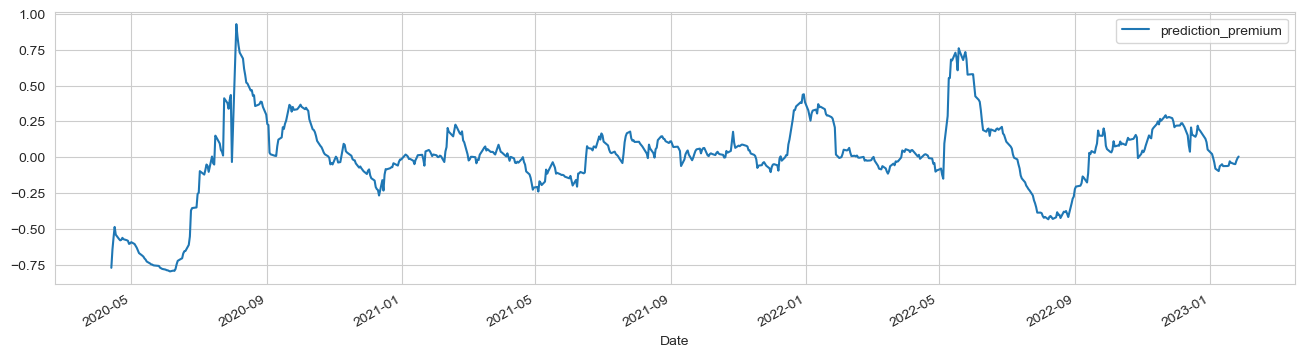

In [52]:
data["prediction_premium"] = (data["fixed_predictions"] - data["variance"])/data["variance"]
data[["prediction_premium"]].plot(figsize = (16,4))

plt.show()

In [54]:
data["premium_diff"] = data["prediction_premium"].diff()
std = data["prediction_premium"].diff().std()

data["signal"] = data.apply(lambda x: 1 if (x["prediction_premium"] < 0) & (x["premium_diff"] > std)
                            else (-1 if (x["prediction_premium"] > 0) & (x["premium_diff"] <- std) else np.nan), axis = 1)

data["signal"] = data["signal"].ffill(limit = 5)
data["strategy_return"] = (data["stock_log_ret"] * data["signal"])

data

,stock_log_ret,variance,predictions,fixed_predictions,prediction_premium,premium_diff,signal,strategy_return
Date,,,,,,,,
2020-04-13,0.019438,0.001727,0.000785,0.000393,-0.772712,NaN,NaN,NaN
2020-04-14,0.049269,0.001756,0.001070,0.000621,-0.646023,0.126689,1.0,0.049269
2020-04-15,-0.009169,0.001756,0.001195,0.000769,-0.561738,0.084285,1.0,-0.009169
2020-04-16,0.007914,0.001756,0.001388,0.000900,-0.487300,0.074438,1.0,0.007914
2020-04-17,-0.013661,0.001758,0.000384,0.000807,-0.541144,-0.053844,1.0,-0.013661
...,...,...,...,...,...,...,...,...
2023-01-23,0.023229,0.000592,0.000567,0.000563,-0.047923,-0.009515,NaN,NaN
2023-01-24,0.010013,0.000593,0.000568,0.000564,-0.048730,-0.000807,NaN,NaN
2023-01-25,-0.004712,0.000577,0.000553,0.000563,-0.025227,0.023502,NaN,NaN


<AxesSubplot:xlabel='Date'>

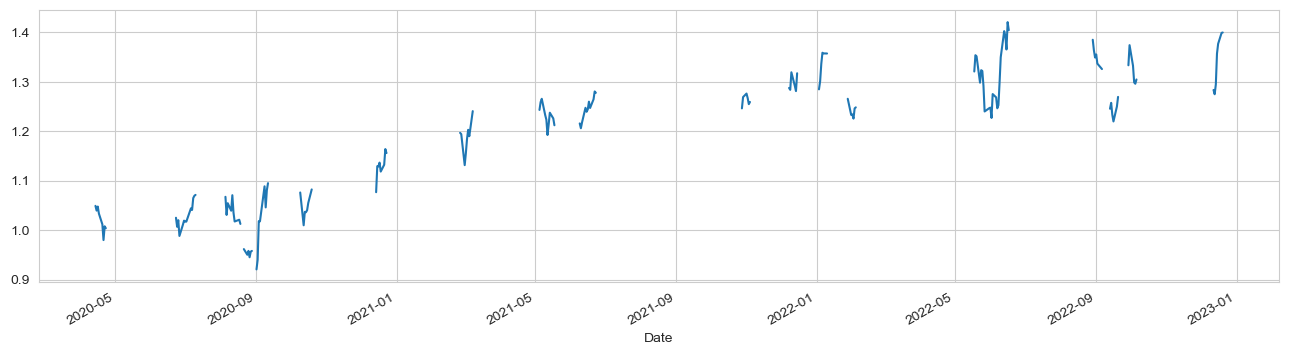

In [55]:
np.exp(np.log1p(data["strategy_return"]).cumsum()).plot(figsize=(16,4))

In [57]:
print(f'Sharpe Ratio {(data["strategy_return"].mean()/data["strategy_return"].std()) * (252**.5)}')

Sharpe Ratio 1.5612161304928316


In [66]:
data.to_csv('data.csv', index=False)